# Stereoseq create segmented objects

## Load packages

In [1]:
import anndata as ad 
import scanpy as sc 
import numpy as np
import pandas as pd
from skimage import io
from skimage.transform import AffineTransform, warp
from skimage.measure import regionprops_table
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.ndimage import map_coordinates
from skimage.measure import regionprops_table
from shapely.geometry import Point, Polygon
from scipy.spatial import cKDTree
from collections import defaultdict
import matplotlib.colors as mcolors


## Step 0: Load Anndata object and pre-registered image

In [ ]:
# Load the AnnData object
STO = sc.read_h5ad('/fs/cbsuvlaminck5/workdir/lt425/202411_stereoseq/short/D112/adata_bac_20umbinned.h5ad')


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
border = pd.read_csv('/fs/cbsuvlaminck5/workdir/lt425/202411_stereoseq/short/D112/contour_lumen.csv', header=None)
border.columns = ['x', 'y']
border

,x,y
0,2706.0,370.0
1,2705.0,371.0
2,2699.0,371.0
3,2698.0,372.0
4,2694.0,372.0
...,...,...
8043,2744.0,372.0
8044,2740.0,372.0
8045,2739.0,371.0
8046,2734.0,371.0


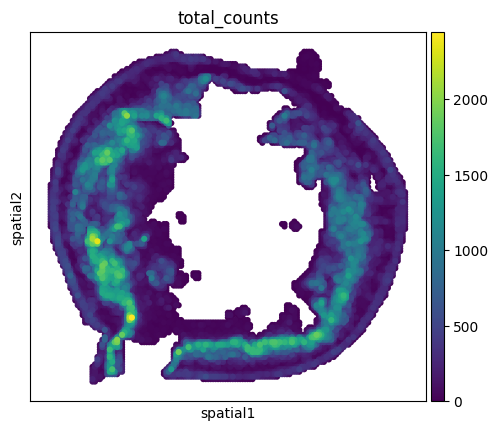

In [5]:
sc.pl.spatial(STO,color='total_counts',spot_size=100)

/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


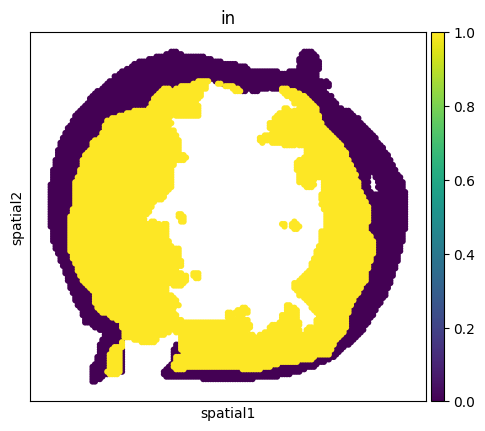

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.path import Path

# Load the border
border = pd.read_csv('/fs/cbsuvlaminck5/workdir/lt425/202411_stereoseq/short/D112/contour_lumen.csv', header=None)
border.columns = ['x', 'y']

# Apply the estimated offsets
x_offset = 4500
y_offset = 3500  # lowered to improve alignment

border_shifted = border.copy()
border_shifted['x'] += x_offset
border_shifted['y'] += y_offset

border['x'] += x_offset
border['y'] += y_offset

# Create path object for contour
contour_path = Path(border[['x', 'y']].values)

# Get coordinates of spots
coords = STO.obsm['spatial']

# Check whether each point is inside the path
inside_mask = contour_path.contains_points(coords)

# Save to obs
STO.obs['in'] = inside_mask.astype(int)
sc.pl.spatial(STO,color='in',spot_size=100)


In [45]:
def calculate_inward_bins_from_contour(adata, contour_df, x_offset=0, y_offset=0, num_bins=5):
    """
    Assign bins based on inward distance from a contour:
    - bin = 0 → outside the contour
    - bin = 1 → near edge inside
    - bin = num_bins-1 → deepest inside
    """
    from matplotlib.path import Path
    from scipy.spatial import distance_matrix
    import numpy as np
    import pandas as pd

    # Shift contour
    border = contour_df.copy()
    border['x'] += x_offset
    border['y'] += y_offset

    # Construct path from contour
    path = Path(border[['x', 'y']].values)
    coords = adata.obsm['spatial']

    # Determine which spots are inside
    inside_mask = path.contains_points(coords)
    adata.obs['in'] = inside_mask.astype(int)

    # Extract coordinates
    inside_coords = coords[inside_mask]
    outside_coords = coords[~inside_mask]

    # Edge case: no interior or no exterior
    if len(inside_coords) == 0 or len(outside_coords) == 0:
        adata.obs['bin'] = pd.Categorical([np.nan] * adata.shape[0], categories=range(num_bins))
        return adata

    # Compute distance from each inside point to nearest outside point
    dist_matrix = distance_matrix(inside_coords, outside_coords)
    min_distances = dist_matrix.min(axis=1)

    # Assign distances to obs
    distance_series = pd.Series(np.nan, index=adata.obs_names)
    distance_series.iloc[np.where(inside_mask)[0]] = min_distances
    distance_series.iloc[np.where(~inside_mask)[0]] = 0  # outside = distance 0

    # Bin distances: bin=0 outside, 1+ = deeper inside
    binned = pd.cut(distance_series, bins=num_bins-1, labels=range(1, num_bins))
    binned.iloc[np.where(~inside_mask)[0]] = 0
    binned = binned.astype("category")
    binned = binned.cat.set_categories(range(num_bins))

    adata.obs['bin'] = binned
    return adata


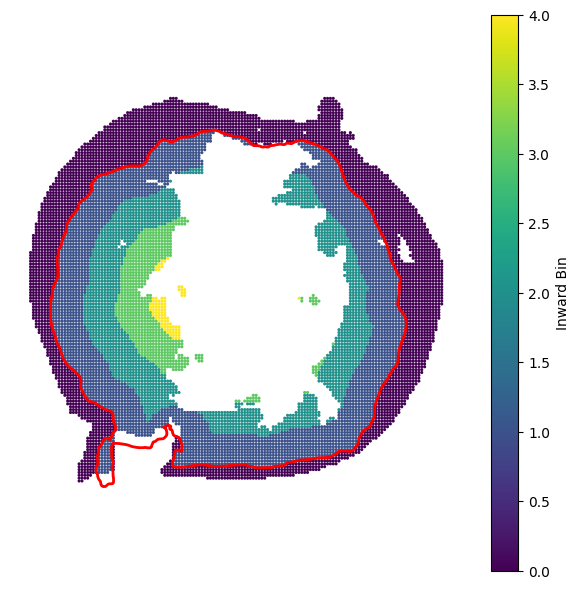

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.spatial import distance_matrix

# --- Load and shift contour ---
border = pd.read_csv('/fs/cbsuvlaminck5/workdir/lt425/202411_stereoseq/short/D112/contour_lumen.csv', header=None)
border.columns = ['x', 'y']
x_offset = 4500
y_offset = 3500
border['x'] += x_offset
border['y'] += y_offset

# --- Compute inward bins ---
coords = STO.obsm['spatial']
path = Path(border[['x', 'y']].values)
inside_mask = path.contains_points(coords)
STO.obs['in'] = inside_mask.astype(int)

inside_coords = coords[inside_mask]
outside_coords = coords[~inside_mask]

num_bins = 5

if len(inside_coords) == 0 or len(outside_coords) == 0:
    STO.obs['bin'] = pd.Categorical([np.nan] * STO.shape[0], categories=range(num_bins))
else:
    dist_matrix = distance_matrix(inside_coords, outside_coords)
    min_distances = dist_matrix.min(axis=1)

    distance_series = pd.Series(np.nan, index=STO.obs_names)
    distance_series.iloc[np.where(inside_mask)[0]] = min_distances
    distance_series.iloc[np.where(~inside_mask)[0]] = 0  # Outside = distance 0

    binned = pd.cut(distance_series, bins=num_bins-1, labels=range(1, num_bins))
    # Ensure 0 is included in the categories
    binned = binned.astype("category")
    binned = binned.cat.set_categories(range(num_bins))
    binned.iloc[np.where(~inside_mask)[0]] = 0
    STO.obs['bin'] = binned

# --- Plot the binned spatial map ---
coords = STO.obsm['spatial']
bins = STO.obs['bin']
numeric_bins = bins.cat.codes

plt.figure(figsize=(6, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=numeric_bins, cmap='viridis', s=5, edgecolor='none')
plt.plot(border['x'], border['y'], color='red', linewidth=2)
plt.colorbar(scatter, label='Inward Bin')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.show()


In [51]:
def plot_phylum_by_inward_bin(
    adata,
    contour_path,
    x_offset=0,
    y_offset=0,
    num_bins=5,
    phylum_key='phylum',
    cmap='tab20'
):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.path import Path
    from scipy.spatial import distance_matrix
    from scipy.sparse import issparse
    import scanpy as sc

    # --- Load and shift contour ---
    border = pd.read_csv(contour_path, header=None)
    border.columns = ['x', 'y']
    border['x'] += x_offset
    border['y'] += y_offset

    # --- Compute inward bins ---
    coords = adata.obsm['spatial']
    path = Path(border[['x', 'y']].values)
    inside_mask = path.contains_points(coords)
    adata.obs['in'] = inside_mask.astype(int)

    inside_coords = coords[inside_mask]
    outside_coords = coords[~inside_mask]

    if len(inside_coords) == 0 or len(outside_coords) == 0:
        adata.obs['bin'] = pd.Categorical([np.nan] * adata.shape[0], categories=range(num_bins))
        return

    dist_matrix = distance_matrix(inside_coords, outside_coords)
    min_distances = dist_matrix.min(axis=1)

    distance_series = pd.Series(np.nan, index=adata.obs_names)
    distance_series.iloc[np.where(inside_mask)[0]] = min_distances
    distance_series.iloc[np.where(~inside_mask)[0]] = 0

    binned = pd.cut(distance_series, bins=num_bins-1, labels=range(1, num_bins))
    binned = binned.astype("object")  # temporarily lose the category lock
    binned.iloc[np.where(~inside_mask)[0]] = 0
    binned = pd.Categorical(binned, categories=range(num_bins))
    adata.obs['bin'] = binned


    # --- Collapse by phylum ---
    X = adata.raw.X if adata.raw is not None else adata.X
    if issparse(X):
        X = X.toarray()

    phylum_map = adata.var[phylum_key]
    unique_phyla = phylum_map.dropna().unique()
    obs_names = adata.obs_names

    phylum_matrix = pd.DataFrame(0, index=obs_names, columns=unique_phyla)
    for phylum in unique_phyla:
        mask = phylum_map == phylum
        if mask.sum() > 0:
            phylum_matrix[phylum] = X[:, mask].sum(axis=1)

    phylum_matrix['bin'] = adata.obs['bin'].values
    collapsed = phylum_matrix.groupby('bin').sum()
    collapsed = collapsed.reindex(range(num_bins), fill_value=0)

    # --- Plot stacked bar ---
    rel_abundance = collapsed.div(collapsed.sum(axis=1), axis=0).fillna(0)

    plt.figure(figsize=(8, 4))
    bottom = np.zeros(rel_abundance.shape[0])

    for phylum in rel_abundance.columns:
        plt.bar(rel_abundance.index, rel_abundance[phylum], bottom=bottom, label=phylum)
        bottom += rel_abundance[phylum].values

    plt.xlabel("Inward Bin")
    plt.ylabel("Relative Abundance")
    plt.title("Phylum Composition Across Inward Bins")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4152340/974487035.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  collapsed = phylum_matrix.groupby('bin').sum()
/tmp/ipykernel_4152340/974487035.py:84: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


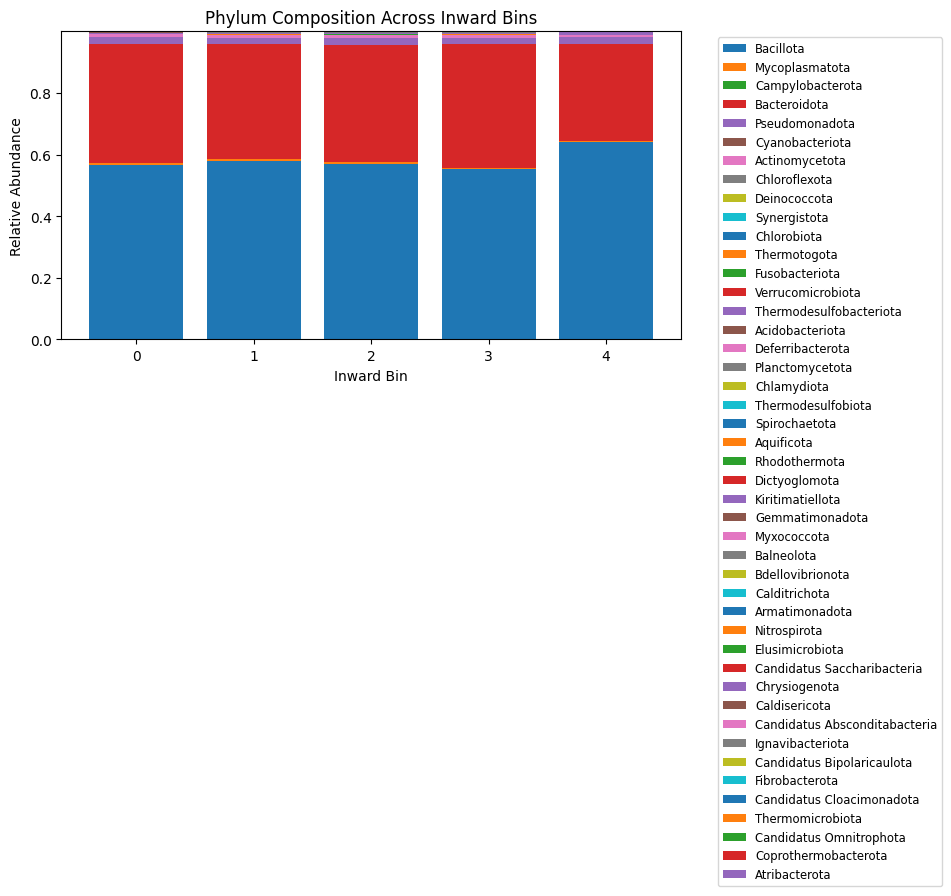

In [52]:
plot_phylum_by_inward_bin(
    adata=STO,
    contour_path='/fs/cbsuvlaminck5/workdir/lt425/202411_stereoseq/short/D112/contour_lumen.csv',
    x_offset=4500,
    y_offset=3500,
    num_bins=5
)


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import issparse

def dot_plot_phyla_zscore(adata, phyla, sample_name="Sample", num_bins=5, min_counts=1, output_file=None, colorbar_output_file=None):
    # Get binned phylum expression
    X = adata.raw.X if adata.raw is not None else adata.X
    if issparse(X): X = X.toarray()
    
    phylum_map = adata.var['phylum']
    obs_names = adata.obs_names
    bin_labels = adata.obs['bin']
    
    # Filter phyla
    available_phyla = phylum_map[phylum_map.isin(phyla)].dropna()
    if available_phyla.empty:
        print("None of the selected phyla found.")
        return
    
    selected_phyla = available_phyla.unique()
    phylum_matrix = pd.DataFrame(0, index=obs_names, columns=selected_phyla)
    
    for phylum in selected_phyla:
        gene_mask = phylum_map == phylum
        phylum_matrix[phylum] = X[:, gene_mask].sum(axis=1)

    phylum_matrix['bin'] = bin_labels.values
    collapsed = phylum_matrix.groupby('bin').sum()
    collapsed = collapsed.reindex(range(num_bins), fill_value=0)

    # Calculate % and z-score
    bin_totals = collapsed.sum(axis=1)
    percent = (collapsed.T / bin_totals).T * 100
    z_scores = (percent - percent.mean()) / percent.std()

    # Add reference gene
    proportions = [1, 5, 20, 50, 100]
    imaginary = 'ImaginaryPhylum'
    for i in range(num_bins):
        percent.loc[i, imaginary] = proportions[i]
        z_scores.loc[i, imaginary] = (proportions[i] - np.mean(proportions)) / np.std(proportions)

    clustered = list(selected_phyla) + [imaginary]

    # Format dataframe for plotting
    plot_data = []
    for ph in clustered:
        for b in range(num_bins):
            plot_data.append({
                'Phylum': ph,
                'Bin': b,
                'Z-score': z_scores.loc[b, ph],
                'Percent': percent.loc[b, ph]
            })
    df = pd.DataFrame(plot_data)

    # Plot
    fig_height = 1.5 * len(clustered) / (len(phyla) + 1)
    fig, ax = plt.subplots(figsize=(0.8, fig_height))
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')
    
    sns.scatterplot(
        data=df,
        x='Bin',
        y='Phylum',
        size='Percent',
        hue='Z-score',
        palette='coolwarm',
        edgecolor='k',
        sizes=(df['Percent'].min(), df['Percent'].max()),
        ax=ax,
        legend=None
    )

    ax.set_xticklabels([])
    plt.yticks(fontsize=8)
    plt.grid(False)
    plt.xlabel('')
    plt.ylabel('')
    plt.subplots_adjust(left=0.0, right=1, top=1, bottom=0.0)
    plt.xlim(-0.5, num_bins - 0.5)
    plt.ylim(-0.5, len(clustered) - 0.5)
    sns.despine(offset=1, trim=True)
    
    if output_file:
        plt.savefig(output_file, format='pdf', dpi=300, transparent=True)
    plt.show()

    # Optional: second plot with colorbar
    fig, ax = plt.subplots(figsize=(1.0, fig_height))
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')

    sns.scatterplot(
        data=df,
        x='Bin',
        y='Phylum',
        size='Percent',
        hue='Z-score',
        palette='coolwarm',
        edgecolor='k',
        sizes=(df['Percent'].min(), df['Percent'].max()),
        ax=ax,
        legend=None
    )

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(0.5)

    norm = plt.Normalize(df['Z-score'].min(), df['Z-score'].max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label='', fraction=0.04, pad=0.02)
    cbar.ax.tick_params(labelsize=6)

    plt.yticks(fontsize=8)
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.subplots_adjust(left=0.0, right=1, top=1, bottom=0.0)
    plt.xlim(-0.35, num_bins - 0.65)
    plt.ylim(-0.5, len(clustered) - 0.5)

    if colorbar_output_file:
        plt.savefig(colorbar_output_file, format='pdf', dpi=300, transparent=True)
    plt.show()


/tmp/ipykernel_4152340/3238640655.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  collapsed = phylum_matrix.groupby('bin').sum()


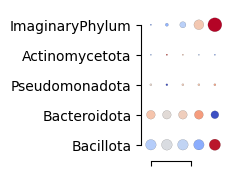

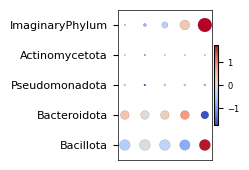

In [54]:
phyla = ["Bacillota", "Bacteroidota", "Pseudomonadota", "Actinomycetota"]
dot_plot_phyla_zscore(
    STO,
    phyla=phyla,
    sample_name="STRS_D",
    num_bins=5,
    output_file="STRS_D_dotplot.pdf",
    colorbar_output_file="STRS_D_dotplot_cb.pdf"
)


## Segmentation

### Trim Data based on ROI

In [4]:
from shapely.geometry import Polygon, Point
# Read the CSV file containing the ROI polygon coordinates
roi_df = pd.read_csv('/workdir/in68/strshd/segmentation/STO1/STO1_heart_polygon.csv')

# Display the first few rows to verify
print(roi_df.head())

# Assuming 'axis-0' is the Y-coordinate and 'axis-1' is the X-coordinate
x_coords = roi_df['axis-1'].values
y_coords = roi_df['axis-0'].values

# Create a list of (x, y) tuples for the polygon vertices
roi_polygon_coords = list(zip(x_coords, y_coords))

# Verify the coordinates
print("Polygon Coordinates:")
for coord in roi_polygon_coords:
    print(coord)
# Create the ROI polygon using shapely
roi_polygon = Polygon(roi_polygon_coords)

# Check if the polygon is valid
if not roi_polygon.is_valid:
    print("The ROI polygon is not valid. Please check the coordinates.")
else:
    print("ROI polygon created successfully.")

# Extract barcode coordinates
barcode_coords = barcode_list[['x', 'y']].values

# Convert barcode coordinates to shapely Points
barcode_points = [Point(xy) for xy in barcode_coords]

# Determine which barcodes are inside the ROI
barcodes_in_roi = np.array([roi_polygon.contains(point) for point in barcode_points])

# Subset the AnnData object
adata_roi1 = STO1[barcodes_in_roi].copy()

# Print the number of barcodes inside the ROI
print(f"Total barcodes inside ROI: {adata_roi1.n_obs}")

   index shape-type  vertex-index        axis-0       axis-1
0      0    polygon             0  20260.788020  2353.302651
1      0    polygon             1  19880.554489  2454.708126
2      0    polygon             2  19418.994081  2768.825626
3      0    polygon             3  19329.246224  3711.178126
4      0    polygon             4  18617.673928  3403.471187
Polygon Coordinates:
(2353.3026505468206, 20260.78801983879)
(2454.708126343019, 19880.554489226022)
(2768.8256262486884, 19418.99408120137)
(3711.178125965696, 19329.246224085466)
(3403.4711872825915, 18617.67392838078)
(3736.820370855955, 17861.227704118148)
(4095.811799319577, 17598.394693992996)
(4435.571544115504, 17611.215816438125)
(4602.246135902186, 17803.532653115064)
(4935.595319475549, 18316.37755092024)
(5472.80135413363, 17944.933917932256)
(5852.199845110405, 17677.71998309689)
(6231.598336087179, 17321.434736649746)
(6653.152214950262, 17098.756457620264)
(7159.01686958596, 16920.61383439667)
(7580.570748449042

/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Total barcodes inside ROI: 2870547


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/home/in68/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


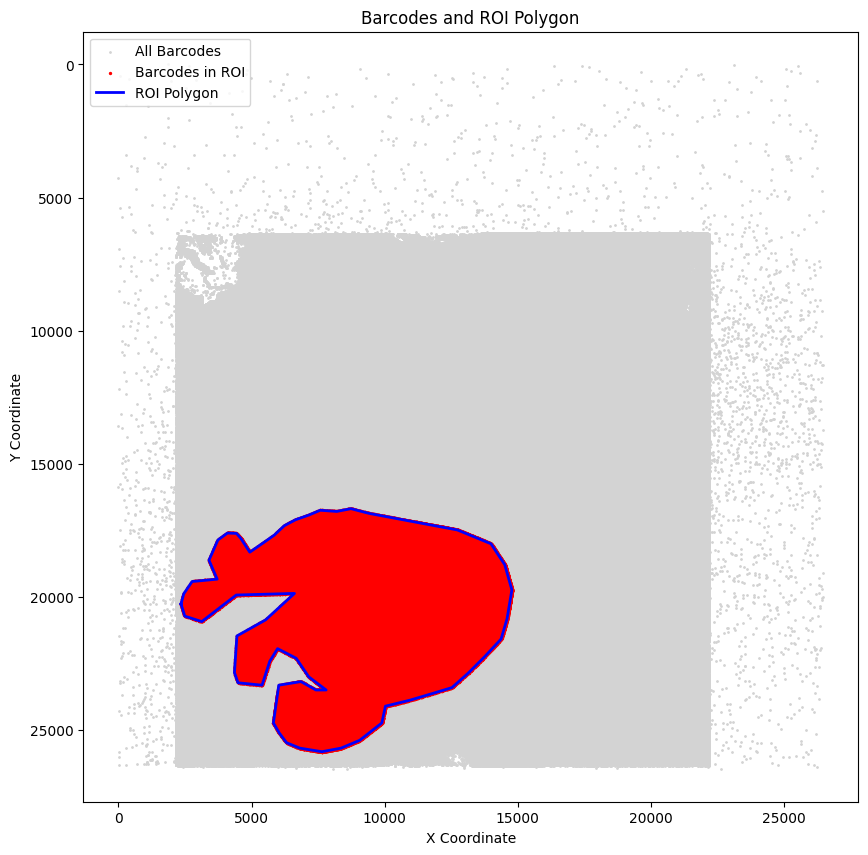

In [5]:
# Visualize Barcode selection
# Plot all barcodes
plt.figure(figsize=(10, 10))
plt.scatter(
    barcode_list['x'],
    barcode_list['y'],
    c='lightgray',
    s=1,
    label='All Barcodes'
)

# Plot barcodes inside the ROI
plt.scatter(
    adata_roi1.obsm['spatial'][:, 0],
    adata_roi1.obsm['spatial'][:, 1],
    c='red',
    s=2,
    label='Barcodes in ROI'
)

# Plot the ROI polygon
x_poly, y_poly = roi_polygon.exterior.xy
plt.plot(x_poly, y_poly, 'blue', linewidth=2, label='ROI Polygon')

plt.title('Barcodes and ROI Polygon')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.legend()
plt.show()

## Cell and tubule segmentation information

In [7]:
# Load the cell segmentation labels image 
cell_labels_image = np.load('/workdir/in68/strshd/segmentation/STO1/labels.npy')  

# # Load the tubule information
# # Path to tubule CSV file by napari
# tubule_csv_path = '/workdir/in68/strshd/segmentation/STO1/STO1_tubules.csv'  # Replace with your actual path

# # Read the CSV file
# tubule_df = pd.read_csv(tubule_csv_path)

# # Verify the structure
# print(tubule_df.head())

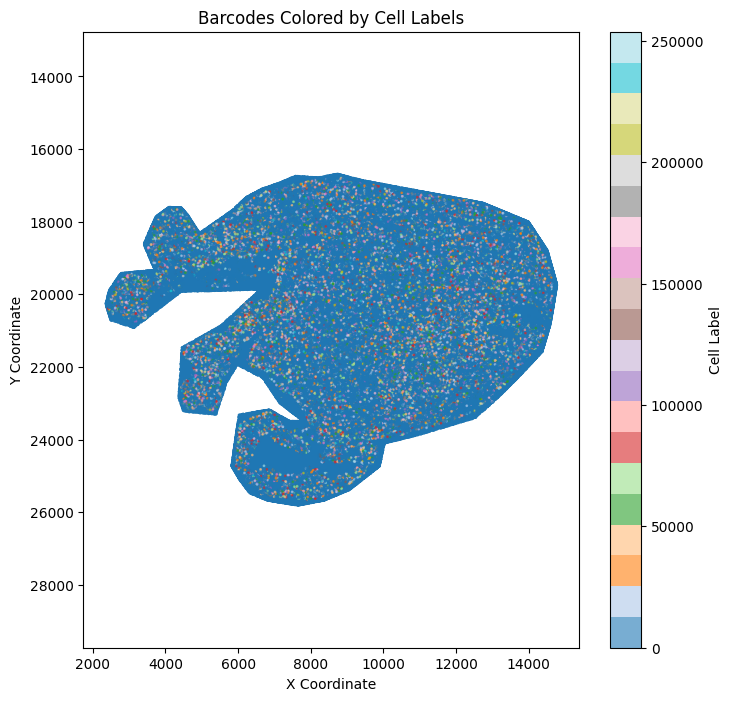

In [8]:
# Extract barcode coordinates from adata
barcode_coords = adata_roi1.obsm['spatial'].copy()  # Shape: (N, 2)

# Convert coordinates to image indices (integers)
barcode_coords_int = barcode_coords.astype(int)

# Ensure coordinates are within image bounds
height, width = cell_labels_image.shape
barcode_coords_int[:, 0] = np.clip(barcode_coords_int[:, 0], 0, width - 1)
barcode_coords_int[:, 1] = np.clip(barcode_coords_int[:, 1], 0, height - 1)

# Map barcodes to cell labels
barcode_cell_labels = cell_labels_image[barcode_coords_int[:, 1], barcode_coords_int[:, 0]]  # Note: Y before X

# Add cell labels to adata.obs
adata_roi1.obs['cell_label'] = barcode_cell_labels

# # Replace 0 with NaN for unsegmented spots (if 0 represents background)
# adata_roi1.obs['cell_label'].replace(0, np.nan, inplace=True)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    adata_roi1.obsm['spatial'][:, 0],
    adata_roi1.obsm['spatial'][:, 1],
    c=adata_roi1.obs['cell_label'],
    cmap='tab20',
    s=1,
    alpha=0.6
)
plt.title('Barcodes Colored by Cell Labels')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.gca().invert_yaxis()  # If needed
plt.axis('equal')
plt.colorbar(scatter, label='Cell Label')
plt.show()

In [116]:
# # Group the DataFrame by 'index' to get each tubule's vertices
# tubule_groups = tubule_df.groupby('index')

# # Initialize a list to store tubule polygons with their IDs
# tubule_polygons = []

# for tubule_id, group in tubule_groups:
#     # Extract X and Y coordinates
#     x_coords = group['axis-1'].values
#     y_coords = group['axis-0'].values
    
#     # Create a list of (x, y) tuples
#     polygon_coords = list(zip(x_coords, y_coords))
    
#     # Create a Polygon object
#     tubule_polygon = Polygon(polygon_coords)
    
#     # Validate the polygon
#     if not tubule_polygon.is_valid:
#         print(f"Warning: Tubule polygon with index {tubule_id} is not valid. Attempting to fix.")
#         tubule_polygon = tubule_polygon.buffer(0)  # Attempt to fix invalid polygons
    
#     # Append to the list with the tubule ID
#     tubule_polygons.append({'tubule_id': tubule_id, 'polygon': tubule_polygon})

# print(f"Total tubules loaded: {len(tubule_polygons)}")

# tubule_labels = []

# # Extract barcode coordinates from adata_roi1 (replace 'adata_roi1' with your AnnData object name)
# barcode_coords = adata_roi1.obsm['spatial'].copy()  # Shape: (N, 2)

# # Iterate over each barcode and assign a tubule label
# for idx, (x, y) in enumerate(barcode_coords):
#     point = Point(x, y)
#     assigned = False
#     for tubule in tubule_polygons:
#         if tubule['polygon'].contains(point):
#             tubule_labels.append(tubule['tubule_id'])
#             assigned = True
#             break
#     if not assigned:
#         tubule_labels.append(np.nan)  # Placeholder for unassigned barcodes

# # Add tubule labels to adata_roi1.obs
# adata_roi1.obs['tubule_label'] = tubule_labels

# # Check the distribution of assignments
# print(adata_roi1.obs['tubule_label'].value_counts(dropna=True))


# ##########################################################################
# #Extend tubules to include all spots -- omit for now 
# from scipy.spatial import cKDTree
# # Identify unassigned barcodes
# unassigned = adata_roi1.obs['tubule_label'].isna()
# unassigned_barcodes = adata_roi1.obs[unassigned].index
# unassigned_coords = adata_roi1.obsm['spatial'][unassigned]

# # Compute centroids of each tubule polygon
# tubule_centroids = np.array([tubule['polygon'].centroid.coords[0] for tubule in tubule_polygons])

# # Build a KDTree for efficient nearest neighbor search
# tubule_tree = cKDTree(tubule_centroids)

# # Query the nearest tubule for each unassigned barcode
# distances, indices = tubule_tree.query(unassigned_coords)

# # Assign the nearest tubule_id to unassigned barcodes
# nearest_tubule_ids = [tubule_polygons[idx]['tubule_id'] for idx in indices]
# adata_roi1.obs.loc[unassigned_barcodes, 'tubule_label'] = nearest_tubule_ids

# # Verify the assignments
# print(f"Assigned {len(nearest_tubule_ids)} unassigned barcodes to the nearest tubules.")

Total tubules loaded: 178
tubule_label
20.0     171619
130.0    133477
81.0     125861
131.0    114447
14.0      99988
          ...  
138.0      3946
45.0       3904
44.0       3315
49.0       1197
22.0        711
Name: count, Length: 178, dtype: int64
Assigned 1307635 unassigned barcodes to the nearest tubules.


In [117]:
# # Step 1: Prepare the data
# # Ensure 'tubule_label' is a string type
# adata_roi1.obs['tubule_label'] = adata_roi1.obs['tubule_label'].astype(str)

# # Remove barcodes without a valid tubule label ('nan' or 'NaN')
# valid_tubule_mask = adata_roi1.obs['tubule_label'].notnull() & (adata_roi1.obs['tubule_label'] != 'nan')
# adata_valid = adata_roi1[valid_tubule_mask].copy()

# # Step 2: Create a mapping from tubule labels to barcode indices
# # This mapping helps us group the data efficiently
# tubule_labels = adata_valid.obs['tubule_label'].values
# barcode_indices = np.arange(adata_valid.n_obs)
# tubule_to_indices = defaultdict(list)

# for idx, tubule in zip(barcode_indices, tubule_labels):
#     tubule_to_indices[tubule].append(idx)

# # Step 3: Aggregate expression data for each tubule
# # Initialize lists to store tubule IDs and aggregated data
# tubule_ids = []
# aggregated_data = []

# for tubule_id, indices in tubule_to_indices.items():
#     # Extract the expression data for the current tubule's barcodes
#     # The data remains in sparse format, avoiding memory issues
#     tubule_data = adata_valid.X[indices, :]  # Sparse matrix

#     # Sum the expression data across the barcodes
#     # The result is a 1 x num_genes sparse matrix
#     tubule_sum = tubule_data.sum(axis=0)  # Axis 0 sums over rows (barcodes)

#     # Ensure the result is a CSR sparse matrix
#     if not sp.issparse(tubule_sum):
#         tubule_sum = sp.csr_matrix(tubule_sum)

#     # Append the tubule ID and the summed data
#     tubule_ids.append(tubule_id)
#     aggregated_data.append(tubule_sum)

# # Step 4: Stack the aggregated data into a single sparse matrix
# # Each 'tubule_sum' is a 1 x num_genes matrix; we stack them vertically
# collapsed_matrix = sp.vstack(aggregated_data)

# # Step 5: Create a new AnnData object with the collapsed data
# # Create an observation DataFrame with tubule IDs and metadata
# obs_df = pd.DataFrame({'tubule_label': tubule_ids})
# obs_df['num_barcodes'] = [len(tubule_to_indices[tubule]) for tubule in tubule_ids]
# obs_df.set_index('tubule_label', inplace=True)

# # Create the new AnnData object
# adata_tubules = sc.AnnData(
#     X=collapsed_matrix,
#     var=adata_valid.var.copy(),  # Copy gene information
#     obs=obs_df  # Tubule metadata
# )

# # Step 6: Verify the collapsed data
# print(f"Original data: {adata_roi1.n_obs} barcodes, {adata_roi1.n_vars} genes.")
# print(f"Collapsed data: {adata_tubules.n_obs} tubules, {adata_tubules.n_vars} genes.")

# # Step 7: Save the collapsed AnnData object
# adata_tubules.write('adata_tubules_collapsed.h5ad')
# print("Collapsed tubule data saved to 'adata_tubules_collapsed.h5ad'.")

# # Proceed with downstream analysis using 'adata_tubules'


/home/in68/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/in68/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Original data: 6505841 barcodes, 78298 genes.
Collapsed data: 178 tubules, 78298 genes.
Collapsed tubule data saved to 'adata_tubules_collapsed.h5ad'.


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.war

Original data: 2870547 barcodes, 78298 genes.
Collapsed data: 21177 cells, 78298 genes.
Collapsed cell data saved to 'adata_cells_collapsed.h5ad'.


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


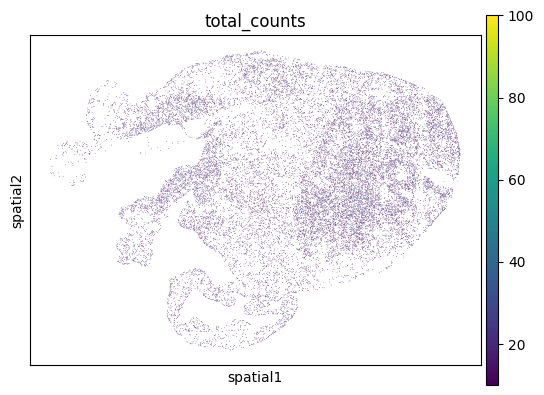

In [10]:
# Assuming adata_roi1 is your AnnData object
# 'cell_label' and 'tubule_label' are in adata_roi1.obs
# 'spatial' coordinates are in adata_roi1.obsm['spatial']

# Step 1: Prepare the data

# Ensure 'cell_label' is a string type
adata_roi1.obs['cell_label'] = adata_roi1.obs['cell_label'].astype(str)

# Remove barcodes without a valid cell label ('nan' or 'NaN')
# Also remove all spots belonging to cell with cell_label '0' (unassigned)
valid_cell_mask = (
    adata_roi1.obs['cell_label'].notnull() &
    (adata_roi1.obs['cell_label'] != 'nan') &
    (adata_roi1.obs['cell_label'] != '0')
)
adata_valid = adata_roi1[valid_cell_mask].copy()

# **Compute total counts per cell before collapsing**
# Sum counts per barcode (assuming counts are in adata_valid.X)
barcode_counts = np.array(adata_valid.X.sum(axis=1)).flatten()  # Sum over genes per barcode

# Add barcode counts to obs
adata_valid.obs['barcode_counts'] = barcode_counts

# Group barcode counts by 'cell_label' to compute total counts per cell
cell_total_counts = adata_valid.obs.groupby('cell_label')['barcode_counts'].sum()

# Filter cells with total counts > 10 --- I relaxed to 10 for STO1 heart bcs otherwise segmentation is just too spotty
cells_to_keep = cell_total_counts[cell_total_counts > 10].index.tolist()

# Update adata_valid to keep only barcodes belonging to cells with higher total counts
adata_valid = adata_valid[adata_valid.obs['cell_label'].isin(cells_to_keep)].copy()

# Update cell labels and indices
cell_labels = adata_valid.obs['cell_label'].values
barcode_indices = np.arange(adata_valid.n_obs)

# Step 2: Create a mapping from cell labels to barcode indices
cell_to_indices = defaultdict(list)

for idx, cell in zip(barcode_indices, cell_labels):
    cell_to_indices[cell].append(idx)

# Step 3: Aggregate expression data and compute centroids for each cell
cell_ids = []
aggregated_data = []
cell_centroids = []
# cell_tubule_labels = []

for cell_id, indices in cell_to_indices.items():
    # Expression data for current cell's barcodes (sparse matrix)
    cell_data = adata_valid.X[indices, :]

    # Sum expression data across barcodes
    cell_sum = cell_data.sum(axis=0)
    cell_sum = sp.csr_matrix(cell_sum)

    # Append cell ID and summed data
    cell_ids.append(cell_id)
    aggregated_data.append(cell_sum)

    # Compute centroid of the spots (mean of x and y coordinates)
    coords = adata_valid.obsm['spatial'][indices, :]
    centroid = coords.mean(axis=0)
    cell_centroids.append(centroid)

    # # Determine tubule label for the cell (most frequent among spots)
    # tubule_labels = adata_valid.obs['tubule_label'].iloc[indices]
    # tubule_labels = tubule_labels.dropna()
    # if not tubule_labels.empty:
    #     cell_tubule_label = tubule_labels.mode().iloc[0]
    # else:
    #     cell_tubule_label = np.nan
    # cell_tubule_labels.append(cell_tubule_label)

# Step 4: Stack aggregated data into a single sparse matrix
collapsed_matrix = sp.vstack(aggregated_data)

# Step 5: Create a new AnnData object with the collapsed data
obs_df = pd.DataFrame({
    'cell_label': cell_ids,
    'num_barcodes': [len(indices) for indices in cell_to_indices.values()],
    # 'tubule_label': cell_tubule_labels,
    'total_counts': np.array(collapsed_matrix.sum(axis=1)).flatten()
})
obs_df.set_index('cell_label', inplace=True)

# Create 'spatial' coordinates (centroids)
obsm_dict = {'spatial': np.vstack(cell_centroids)}

# Create the new AnnData object
adata_cells = sc.AnnData(
    X=collapsed_matrix,
    var=adata_valid.var.copy(),
    obs=obs_df,
    obsm=obsm_dict
)

# Step 6: Verify the collapsed data
print(f"Original data: {adata_roi1.n_obs} barcodes, {adata_roi1.n_vars} genes.")
print(f"Collapsed data: {adata_cells.n_obs} cells, {adata_cells.n_vars} genes.")

# # Step 1: Ensure 'tubule_label' is a categorical variable
# adata_cells.obs['tubule_label'] = adata_cells.obs['tubule_label'].astype(str)
# adata_cells.obs['tubule_label'] = adata_cells.obs['tubule_label'].astype('category')

# # Step 2: Get the number of unique tubule labels
# n_categories = adata_cells.obs['tubule_label'].nunique()
# print(f"Number of tubule labels: {n_categories}")

# # Step 3: Get the 'tab20' colormap
# colormap = plt.get_cmap('tab20')

# # Step 4: Generate a list of colors by repeating the 'tab20' colors
# colors = [colormap(i % 20) for i in range(n_categories)]

# # Convert RGBA colors to hex format
# colors_hex = [mcolors.rgb2hex(color) for color in colors]

# # Step 5: Assign colors to 'tubule_label_colors' in 'uns'
# # The colors should correspond to the categories in the same order
# adata_cells.uns['tubule_label_colors'] = colors_hex

# # Optional: Verify that the number of colors matches the number of categories
# print(f"Number of colors assigned: {len(colors_hex)}")


# Step 7: Save the collapsed AnnData object
adata_cells.write('/workdir/in68/strshd/segmentation/STO1/adata_cells_collapsed_heart.h5ad')
print("Collapsed cell data saved to 'adata_cells_collapsed.h5ad'.")
sc.pl.spatial(adata_cells,color=['total_counts'],spot_size=20,vmax=100)

In [120]:
# Assuming 'adata_roi1' is your AnnData object

# For 'tubule_label'

# Step 1: Ensure 'tubule_label' is a categorical variable and handle NaN values
adata_roi1.obs['tubule_label'] = adata_roi1.obs['tubule_label'].astype(str)
adata_roi1.obs['tubule_label'].replace(['nan', 'NaN'], np.nan, inplace=True)
adata_roi1.obs['tubule_label'] = adata_roi1.obs['tubule_label'].astype('category')

# Step 2: Get the number of unique tubule labels, excluding NaN
tubule_categories = adata_roi1.obs['tubule_label'].cat.categories.dropna()
n_tubule_categories = len(tubule_categories)
print(f"Number of tubule labels (excluding NaN): {n_tubule_categories}")

# Step 3: Generate colors for 'tubule_label' using 'tab20' colormap
colormap = plt.get_cmap('tab20')
colors = [colormap(i % 20) for i in range(n_tubule_categories)]
colors_hex = [mcolors.rgb2hex(color) for color in colors]

# Step 4: Assign colors to 'tubule_label_colors' in 'uns'
# The colors correspond to the categories in the same order
adata_roi1.uns['tubule_label_colors'] = colors_hex

# Verify that the number of colors matches the number of categories
print(f"Number of colors assigned to tubule labels: {len(colors_hex)}")

# For 'cell_label'

# Step 5: Ensure 'cell_label' is a categorical variable and handle NaN values
adata_roi1.obs['cell_label'] = adata_roi1.obs['cell_label'].astype(str)
adata_roi1.obs['cell_label'].replace(['nan', 'NaN'], np.nan, inplace=True)
adata_roi1.obs['cell_label'] = adata_roi1.obs['cell_label'].astype('category')

# Step 6: Get the number of unique cell labels, excluding NaN
cell_categories = adata_roi1.obs['cell_label'].cat.categories.dropna()
n_cell_categories = len(cell_categories)
print(f"Number of cell labels (excluding NaN): {n_cell_categories}")

# Step 7: Generate colors for 'cell_label' using a suitable colormap
# If there are many cell labels, consider using a larger colormap or creating one
# For example, using 'tab20' and repeating as necessary
colors_cells = [colormap(i % 20) for i in range(n_cell_categories)]
colors_cells_hex = [mcolors.rgb2hex(color) for color in colors_cells]

# Step 8: Assign colors to 'cell_label_colors' in 'uns'
adata_roi1.uns['cell_label_colors'] = colors_cells_hex

# Verify that the number of colors matches the number of categories
print(f"Number of colors assigned to cell labels: {len(colors_cells_hex)}")

# Save the adata_roi1 object if needed
adata_roi1.write('adata_roi1_STO1.h5ad')

Number of tubule labels (excluding NaN): 178
Number of colors assigned to tubule labels: 178
Number of cell labels (excluding NaN): 149375
Number of colors assigned to cell labels: 149375


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/mi

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f6f383be160> (for post_execute):


KeyboardInterrupt: 

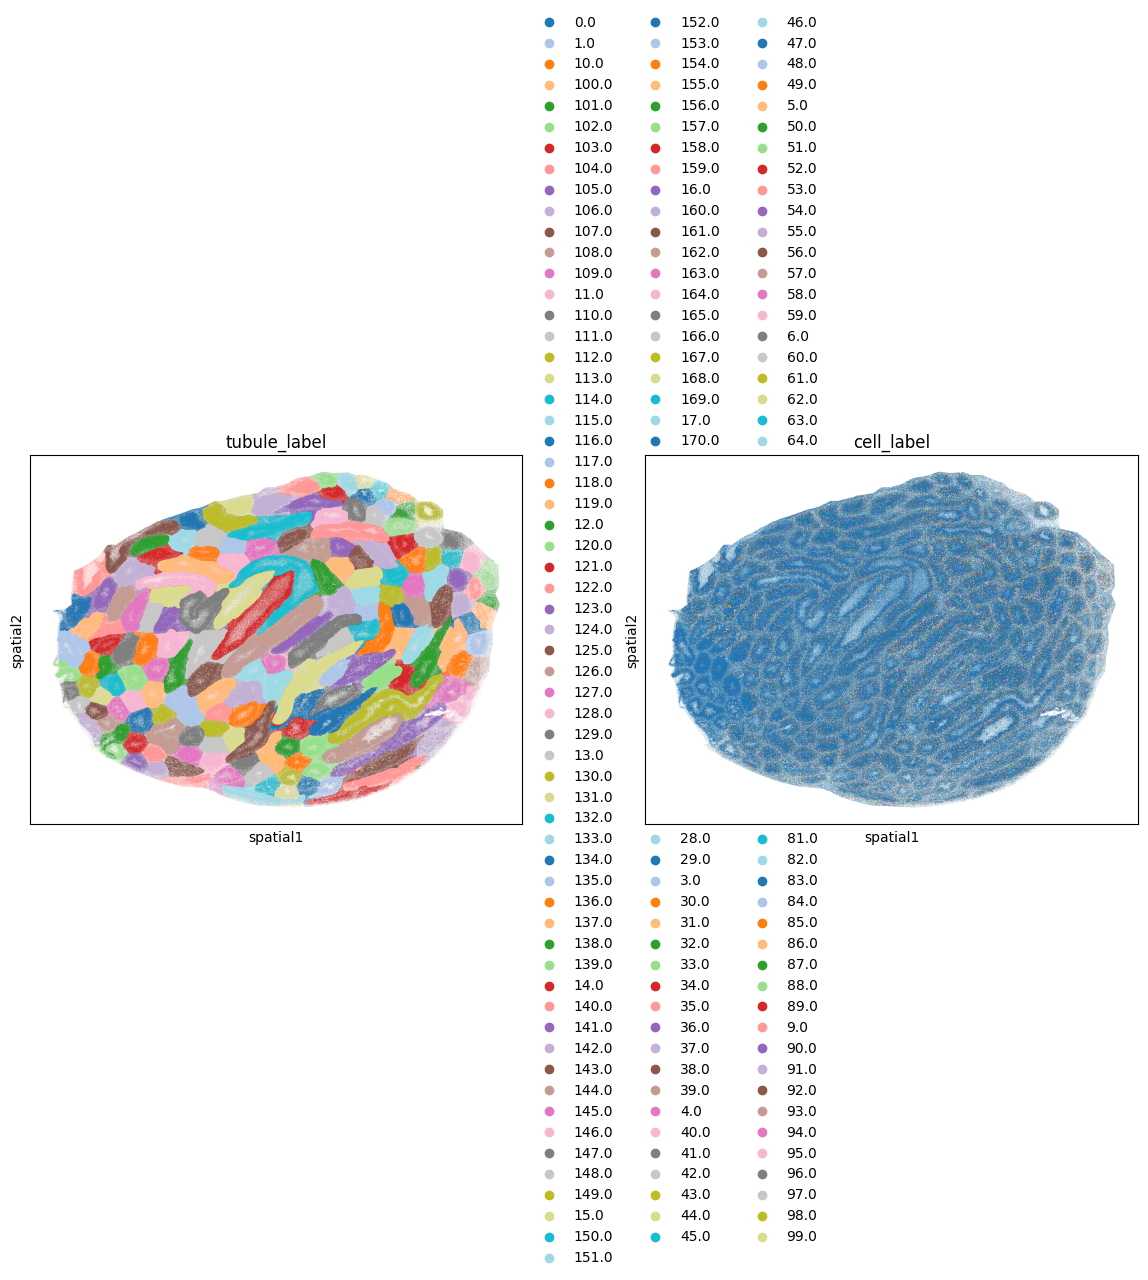

In [122]:
sc.pl.spatial(adata_roi1,color=['tubule_label','cell_label'],spot_size=5,vmax=100)